# Run the following cell for installations

Make sure that the requirements.txt file and the original 'clean-spark-spread-analysis.xlsx' sent by email are in the root next to this .ipynb notebook

In [ ]:
!pip install -r requirements.txt

# 1.) Exploratory Data Analysis

## Evaluate nature of the markets and visualization


ADF Test for Power:
ADF Statistic: -2.2193
p-value: 0.1993
Critical Values:
   1%: -3.4616
   5%: -2.8753
   10%: -2.5741
Result: Power is non-stationary (fail to reject null hypothesis).


ADF Test for Gas:
ADF Statistic: -1.6181
p-value: 0.4737
Critical Values:
   1%: -3.4613
   5%: -2.8751
   10%: -2.5740
Result: Gas is non-stationary (fail to reject null hypothesis).


ADF Test for Certificates:
ADF Statistic: -2.4635
p-value: 0.1246
Critical Values:
   1%: -3.4613
   5%: -2.8751
   10%: -2.5740
Result: Certificates is non-stationary (fail to reject null hypothesis).



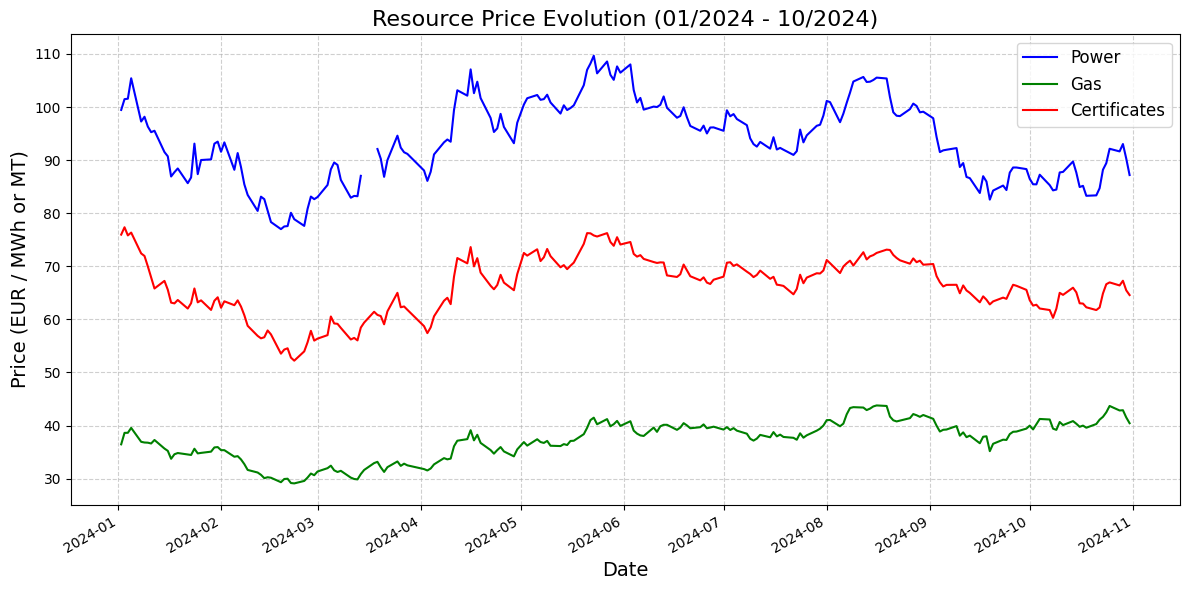

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller

# Load the Excel file
file_path = 'clean-spark-spread-analysis.xlsx'  # Replace with your file path
tab_names = ['POWER_Dec-2024', 'GAS_Dec-2024', 'CO2_EUA_Dec-2024']  # Sheet names

# Load data from all sheets
resource1 = pd.read_excel(file_path, sheet_name=tab_names[0], header=2)
resource2 = pd.read_excel(file_path, sheet_name=tab_names[1], header=2)
resource3 = pd.read_excel(file_path, sheet_name=tab_names[2], header=2)

# Ensure 'Date' column is datetime and sort data
resource1['Date'] = pd.to_datetime(resource1['Date'])
resource2['Date'] = pd.to_datetime(resource2['Date'])
resource3['Date'] = pd.to_datetime(resource3['Date'])

resource1.sort_values('Date', inplace=True)
resource2.sort_values('Date', inplace=True)
resource3.sort_values('Date', inplace=True)

# Filter data for the specified date range
start_date = '2024-01-01'
end_date = '2024-10-31'

resource1 = resource1[(resource1['Date'] >= start_date) & (resource1['Date'] <= end_date)]
resource2 = resource2[(resource2['Date'] >= start_date) & (resource2['Date'] <= end_date)]
resource3 = resource3[(resource3['Date'] >= start_date) & (resource3['Date'] <= end_date)]

# Extract the 'price' columns for stationarity tests
power_prices = resource1['price in EUR / MWh']
gas_prices = resource2['price in EUR / MWh']
certificates_prices = resource3['price in EUR / MT']

# Function to perform Augmented Dickey-Fuller Test
def adf_test(series, label):
    result = adfuller(series.dropna())  # Drop NaN values to avoid errors
    print(f"\nADF Test for {label}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    if result[1] < 0.05:
        print(f"Result: {label} is stationary (reject null hypothesis).\n")
    else:
        print(f"Result: {label} is non-stationary (fail to reject null hypothesis).\n")

# Perform ADF test for each resource
adf_test(power_prices, 'Power')
adf_test(gas_prices, 'Gas')
adf_test(certificates_prices, 'Certificates')

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(resource1['Date'], power_prices, label='Power', color='blue')
plt.plot(resource2['Date'], gas_prices, label='Gas', color='green')
plt.plot(resource3['Date'], certificates_prices, label='Certificates', color='red')

plt.title('Resource Price Evolution (01/2024 - 10/2024)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (EUR / MWh or MT)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Format the date axis to show the first day of each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()  # Auto format the x-axis labels for better readability

plt.tight_layout()
plt.show()


# 2.) Estimate commodities market daily prices (December 2024)

## Forecasting process using Prophet from Meta

15:26:46 - cmdstanpy - INFO - Chain [1] start processing
15:26:46 - cmdstanpy - INFO - Chain [1] done processing
15:26:46 - cmdstanpy - INFO - Chain [1] start processing
15:26:46 - cmdstanpy - INFO - Chain [1] done processing
15:26:46 - cmdstanpy - INFO - Chain [1] start processing
15:26:46 - cmdstanpy - INFO - Chain [1] done processing


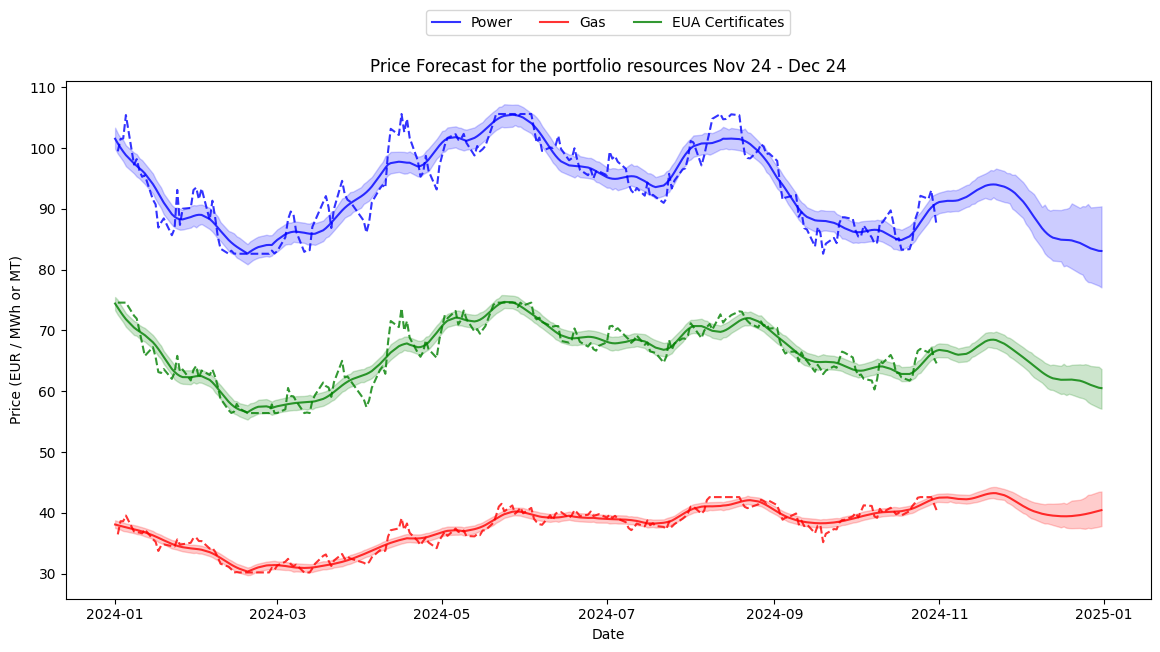

In [ ]:
# Step 1: Import libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 2: Define function for forecasting
def forecast_resource(sheet_name, price_column, start_date, end_date):
    # Load data
    df = pd.read_excel(
        'clean-spark-spread-analysis.xlsx',
        engine='openpyxl',
        sheet_name=sheet_name,
        header=2  # Header row is the 3rd row (zero-indexed as 2)
    )
    df = df.rename(columns={'Date': 'ds', price_column: 'y'})  # Parametrize price column
    df['ds'] = pd.to_datetime(df['ds'])  # Convert 'Date' column to datetime

    df = df[(df['ds'] >= '2024-01-01') & (df['ds'] <= '2024-10-31')]

    df = df.dropna(subset=['ds', 'y'])
    q_low, q_high = df['y'].quantile([0.05, 0.95])
    df['y'] = df['y'].clip(lower=q_low, upper=q_high)

    # Initialize the model
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.2,
        interval_width=0.5

    )

    # Adding custom monthly seasonality
    model.add_seasonality(name='quarterly', period=90, fourier_order=5)

    # Fit the model
    model.fit(df)

    # Create future dataframe with appropriate frequency
    to_predict_df = pd.DataFrame({
        'ds': pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' for business days only
    })

    # Make the forecast
    forecast = model.predict(to_predict_df)

    return df, forecast

# Step 3: Forecast for each resource
start_date = '2024-01-01'
end_date = '2024-12-31'

commodities = {
    'POWER_Dec-2024': ('price in EUR / MWh', 'Power'),
    'GAS_Dec-2024': ('price in EUR / MWh', 'Gas'),
    'CO2_EUA_Dec-2024': ('price in EUR / MT', 'EUA Certificates')
}

results = {}
dataframes = {}  # To store DataFrames for each resource
for sheet_name, (price_column, label) in commodities.items():
    original_data, forecast_data = forecast_resource(sheet_name, price_column, start_date, end_date)
    results[label] = (original_data, forecast_data)

    # Filter forecast data for the date range 2024-12-01 to 2024-12-31
    filtered_forecast = forecast_data[
        (forecast_data['ds'] >= '2024-12-01') & (forecast_data['ds'] <= '2024-12-31')
    ][['ds', 'yhat']]  # Keep only date and predicted values (yhat)

    # Rename columns back to original headers
    filtered_forecast.rename(columns={
        'ds': 'Date',
        'yhat': price_column  # Use the original price column name
    }, inplace=True)

    # Add the filtered forecast to the dataframes dictionary
    dataframes[label] = filtered_forecast

# Step 4: Store the filtered DataFrames in separate variables for easier access
power_forecast_df = dataframes['Power']
gas_forecast_df = dataframes['Gas']
eua_certificates_forecast_df = dataframes['EUA Certificates']

# Step 4: Plot the results
plt.figure(figsize=(14, 7))

# Define colors for the plot
colors = {
    'Power': 'blue',
    'Gas': 'red',
    'EUA Certificates': 'green'
}

for label, (original_data, forecast_data) in results.items():
    # Define base color for this resource
    base_color = colors[label]

    # Plot the original data with a darker tone (no label, to avoid multiple legend entries)
    plt.plot(original_data['ds'], original_data['y'], color=base_color, linestyle='--', alpha=0.8)

    # Plot the forecasted data (with label for legend)
    plt.plot(forecast_data['ds'], forecast_data['yhat'], label=label, color=base_color, alpha=0.8)

    # Plot the uncertainty intervals with a semi-transparent fill (no label)
    plt.fill_between(
        forecast_data['ds'],
        forecast_data['yhat_lower'],
        forecast_data['yhat_upper'],
        color=base_color,
        alpha=0.2
    )

# Adding labels and title
plt.title('Price Forecast for the portfolio resources Nov 24 - Dec 24')
plt.xlabel('Date')
plt.ylabel('Price (EUR / MWh or MT)')

# Adjust legend to only include one entry per resource
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, handlelength=2)
plt.subplots_adjust(top=0.85)  # Add space for the legend above the plot

plt.show()

## Forecasted market prices for december 2024 into dataframes to be used later in below cells

In [ ]:
print("Power Forecast:")
print(power_forecast_df)
print("\nGas Forecast:")
print(gas_forecast_df)
print("\nEUA Certificates Forecast:")
print(eua_certificates_forecast_df)

Power Forecast:
          Date  price in EUR / MWh
240 2024-12-02           91.201531
241 2024-12-03           90.627994
242 2024-12-04           90.008884
243 2024-12-05           89.357943
244 2024-12-06           88.692854
245 2024-12-09           86.820933
246 2024-12-10           86.305423
247 2024-12-11           85.870102
248 2024-12-12           85.522454
249 2024-12-13           85.263153
250 2024-12-16           84.922201
251 2024-12-17           84.897256
252 2024-12-18           84.881581
253 2024-12-19           84.854846
254 2024-12-20           84.800321
255 2024-12-23           84.389454
256 2024-12-24           84.176597
257 2024-12-25           83.944288
258 2024-12-26           83.709842
259 2024-12-27           83.491756
260 2024-12-30           83.088708
261 2024-12-31           83.064595

Gas Forecast:
          Date  price in EUR / MWh
240 2024-12-02           41.124436
241 2024-12-03           40.875987
242 2024-12-04           40.648438
243 2024-12-05          

## Portfolio cost estimation

Note: Gas will be scaled to 24 hours, 31 days because in the excel file provided the formula for the power was scaled the same way

In [ ]:
import pandas as pd

# Example DataFrames for daily unit prices (replace these with your actual data)
power_prices = power_forecast_df
gas_prices = gas_forecast_df
eua_prices = eua_certificates_forecast_df

# Total quantities for the whole month
total_power_quantity = 173352  # quantity in MWh
total_gas_quantity = -466*24*31    # quantity in MWh
total_eua_quantity = -104011.2   # quantity in tons

# Count the number of business days in December
business_days_in_month = len(pd.date_range("2024-12-01", "2024-12-31", freq="B"))

# Normalize quantities over business days
power_quantity_per_day = total_power_quantity / business_days_in_month
gas_quantity_per_day = total_gas_quantity / business_days_in_month
eua_quantity_per_day = total_eua_quantity / business_days_in_month


# Calculate daily costs for each resource
power_prices["Daily Cost"] = power_prices["price in EUR / MWh"] * power_quantity_per_day
gas_prices["Daily Cost"] = gas_prices["price in EUR / MWh"] * gas_quantity_per_day
eua_prices["Daily Cost"] = eua_prices["price in EUR / MT"] * eua_quantity_per_day

# Combine daily costs into a single DataFrame
portfolio_df = pd.DataFrame({"Date": power_prices["Date"]})
portfolio_df["Power Cost"] = power_prices["Daily Cost"]
portfolio_df["Gas Cost"] = gas_prices["Daily Cost"]
portfolio_df["EUA Cost"] = eua_prices["Daily Cost"]

# Add a column for the total daily portfolio cost
portfolio_df["Total Cost"] = (
    portfolio_df["Power Cost"] + portfolio_df["Gas Cost"] + portfolio_df["EUA Cost"]
)

# Output the portfolio value DataFrame
print(portfolio_df)

# Calculate the total sums for each resource and the total portfolio cost
total_power_cost = portfolio_df["Power Cost"].sum()
total_gas_cost = portfolio_df["Gas Cost"].sum()
total_eua_cost = portfolio_df["EUA Cost"].sum()
total_portfolio_cost = portfolio_df["Total Cost"].sum()

# Elegant print output
output = f"""
Summary of Costs for December 2024 (Business Days Only):
---------------------------------------------------
Total Power Cost: €{total_power_cost:,.2f}
Total Gas Cost:   €{total_gas_cost:,.2f}
Total EUA Cost:   €{total_eua_cost:,.2f}
---------------------------------------------------
Total Portfolio Cost: €{total_portfolio_cost:,.2f}
"""

print(output)


          Date     Power Cost       Gas Cost       EUA Cost     Total Cost
240 2024-12-02  718634.898324 -648091.208996 -310080.161609 -239536.472282
241 2024-12-03  714115.640752 -644175.823633 -308474.402858 -238534.585739
242 2024-12-04  709237.276037 -640589.826026 -306835.717300 -238188.267289
243 2024-12-05  704108.095191 -637370.263575 -305162.242538 -238424.410923
244 2024-12-06  698867.439528 -634528.710492 -303462.818781 -239124.089746
245 2024-12-09  684117.378026 -628110.045741 -298483.531044 -242476.198759
246 2024-12-10  680055.353281 -626567.709886 -297004.556100 -243516.912705
247 2024-12-11  676625.174337 -625266.353944 -295695.886549 -244337.066157
248 2024-12-12  673885.838463 -624177.756630 -294598.434809 -244890.352976
249 2024-12-13  671842.641889 -623281.662881 -293739.729453 -245178.750445
250 2024-12-16  669156.062475 -621669.104162 -292583.367152 -245096.408839
251 2024-12-17  668959.507040 -621495.263281 -292563.133255 -245098.889496
252 2024-12-18  668835.99

# 3.) Task 1 and 3: Calculate the daily Value-at-Risk (VaR) of the portfolio using a 66 working day lookback period and display how VaR of the portfolio evolves over time


### Non-parametric method

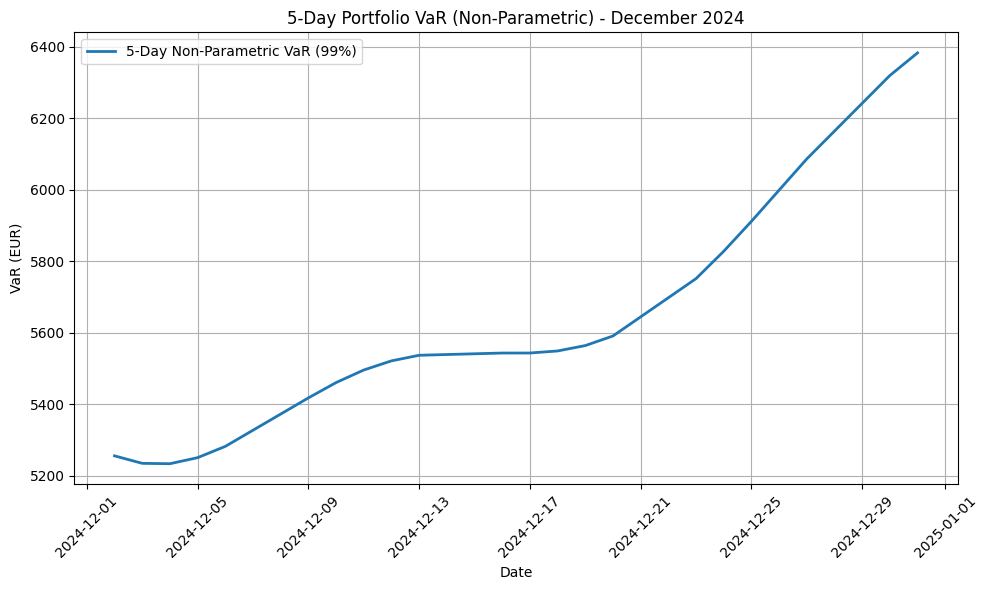

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load historical prices from the first Excel file
historical_file_path = 'clean-spark-spread-analysis.xlsx'  # Update this with the correct file path
historical_prices = {
    "Power": pd.read_excel(historical_file_path, sheet_name="POWER_Dec-2024", skiprows=2),
    "Gas": pd.read_excel(historical_file_path, sheet_name="GAS_Dec-2024", skiprows=2),
    "Certificates": pd.read_excel(historical_file_path, sheet_name="CO2_EUA_Dec-2024", skiprows=2)
}

# Ensure the "Date" column is in datetime format and filter historical price data to the required period (01/01/2024 - 31/10/2024)
lookback_period = 66
end_date = '2024-10-31'
start_date = pd.date_range(end=end_date, periods=lookback_period, freq="B")[0].strftime('%Y-%m-%d')

historical_price_data = {
    resource: df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].rename(columns={df.columns[1]: 'Price'})
    for resource, df in historical_prices.items()
}

# Calculate daily returns for each resource from historical data
returns = {
    resource: df['Price'].pct_change(fill_method=None).dropna()
    for resource, df in historical_price_data.items()
}

# Combine returns into a single DataFrame
returns_df = pd.concat(returns, axis=1).dropna()
returns_df.columns = [resource for resource in returns.keys()]

# Mock portfolio costs for December 2024 with business day dates
december_dates = pd.date_range(start='2024-12-01', end='2024-12-31', freq="B")


# Define cost evolution
cost_evolution = {
    "Power": portfolio_df["Power Cost"],
    "Gas": portfolio_df["Gas Cost"],
    "Certificates": portfolio_df["EUA Cost"]
}

# Function to calculate non-parametric VaR
def calculate_non_parametric_var(returns_df, cost_evolution, confidence_level=0.99, holding_period=5):
    # Convert returns to NumPy for efficient calculations
    returns_array = returns_df.to_numpy()

    # Daily costs for December as a NumPy array
    december_costs = np.array([
        cost_evolution["Power"].values,
        cost_evolution["Gas"].values,
        cost_evolution["Certificates"].values
    ])
    
    # Normalize daily weights (preserve directionality, normalize by absolute sum)
    december_weights = december_costs / np.abs(december_costs).sum(axis=0)

    # Calculate 5-day VaR for each day in December using historical returns
    portfolio_var = []
    for day_index, weights in enumerate(december_weights.T):  # Iterate over daily weights
        # Calculate portfolio returns for this day's weights
        portfolio_returns = returns_array @ weights
        
        # Calculate daily VaR as the empirical percentile of portfolio returns
        daily_var = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
        
        # Scale daily VaR to 5-day VaR
        var_5_day = daily_var * np.sqrt(holding_period)
        
        # Scale to actual portfolio cost for the current day
        var_5_day_scaled = var_5_day * np.abs(december_costs[:, day_index].sum())
        
        portfolio_var.append(var_5_day_scaled)
    
    return portfolio_var

# Calculate 5-day portfolio VaR for December dates
portfolio_var_5_day = calculate_non_parametric_var(returns_df, cost_evolution)

# Plot 5-day non-parametric portfolio VaR with December dates
plt.figure(figsize=(10, 6))
plt.plot(portfolio_df['Date'], portfolio_var_5_day, label='5-Day Non-Parametric VaR (99%)', linewidth=2)
plt.title('5-Day Portfolio VaR (Non-Parametric) - December 2024')
plt.xlabel('Date')
plt.ylabel('VaR (EUR)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


# 4.) Task 2: Define which markets are most closely correlated

### Option 1: Market correlations for the lookback period of 66 days from 2024-10-31

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load historical prices from the first Excel file
historical_file_path = 'clean-spark-spread-analysis.xlsx'  # Update this with the correct file path
historical_prices = {
    "Power": pd.read_excel(historical_file_path, sheet_name="POWER_Dec-2024", skiprows=2),
    "Gas": pd.read_excel(historical_file_path, sheet_name="GAS_Dec-2024", skiprows=2),
    "Certificates": pd.read_excel(historical_file_path, sheet_name="CO2_EUA_Dec-2024", skiprows=2)
}

# Ensure the "Date" column is in datetime format and filter historical price data to the required period (01/01/2024 - 31/10/2024)
lookback_period=66
start_date = pd.date_range(end=end_date, periods=lookback_period, freq="B")[0].strftime('%Y-%m-%d')
end_date = '2024-10-31'

historical_price_data = {
    resource: df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].rename(columns={df.columns[1]: 'Price'})
    for resource, df in historical_prices.items()
}

# Calculate daily returns for each resource from historical data
returns = {
    resource: df['Price'].pct_change(fill_method=None).dropna()
    for resource, df in historical_price_data.items()
}

# Combine returns into a single DataFrame
returns_df = pd.concat(returns, axis=1).dropna()
returns_df.columns = [resource for resource in returns.keys()]

# Calculate the correlation matrix of historical returns
correlation_matrix = returns_df.corr()

# Find the most closely correlated markets
most_correlated = correlation_matrix.unstack().sort_values(ascending=False)

# Drop self-correlations (correlation of a market with itself is always 1)
most_correlated = most_correlated[most_correlated < 1]

# Display the most correlated pair
most_correlated_pair = most_correlated.idxmax()
highest_correlation = most_correlated.max()

print("Most closely correlated markets:")
print(f"{most_correlated_pair[0]} and {most_correlated_pair[1]} with correlation coefficient: {highest_correlation:.2f}")

# Optionally, print the full correlation matrix for reference
print("\nCorrelation matrix:")
print(correlation_matrix)


Most closely correlated markets:
Gas and Power with correlation coefficient: 0.84

Correlation matrix:
                 Power       Gas  Certificates
Power         1.000000  0.842693      0.756891
Gas           0.842693  1.000000      0.589837
Certificates  0.756891  0.589837      1.000000


### Option 2: Market correlations "considering the December 2024 deliveries" (based on forecasted values)

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use the portfolio_df for December 2024 costs
cost_evolution = {
    "Power": portfolio_df["Power Cost"],
    "Gas": portfolio_df["Gas Cost"],
    "Certificates": portfolio_df["EUA Cost"]
}

# Calculate daily returns for each resource from december forecasted data
returns = {
    resource: cost_evolution[resource].pct_change() for resource in cost_evolution
}

# Combine returns into a single DataFrame
returns_df = pd.concat(returns, axis=1).dropna()
returns_df.columns = [resource for resource in returns.keys()]

# Calculate the correlation matrix of historical returns
correlation_matrix = returns_df.corr()

# Find the most closely correlated markets
most_correlated = correlation_matrix.unstack().sort_values(ascending=False)

# Drop self-correlations (correlation of a market with itself is always 1)
most_correlated = most_correlated[most_correlated < 1]

# Display the most correlated pair
most_correlated_pair = most_correlated.idxmax()
highest_correlation = most_correlated.max()

print("Most closely correlated markets:")
print(f"{most_correlated_pair[0]} and {most_correlated_pair[1]} with correlation coefficient: {highest_correlation:.2f}")

# Optionally, print the full correlation matrix for reference
print("\nCorrelation matrix:")
print(correlation_matrix)


Most closely correlated markets:
Certificates and Power with correlation coefficient: 0.96

Correlation matrix:
                 Power       Gas  Certificates
Power         1.000000  0.666070      0.963429
Gas           0.666070  1.000000      0.516393
Certificates  0.963429  0.516393      1.000000
